In [1]:
import sys
import os
sys.path.append(os.path.abspath('../src'))

### Test New Datasets

In [2]:
from datasets import (
    Puerto_Rico_Building_Dataset, 
    Cloud_DrivenData_Dataset,
    OpenCities_Building_Dataset
)

In [4]:
from pathlib import Path
DATA_DIR = Path.cwd().parent.resolve() / "data/data_samples/Cloud_DrivenData/final/public"
TRAIN_FEATURES = DATA_DIR / "train_features"
TRAIN_LABELS = DATA_DIR / "train_labels"
TRAIN_META_FILE = DATA_DIR / "train_metadata.csv"
BANDS = ["B04", "B03", "B02"] #"B08"
assert TRAIN_FEATURES.exists()
assert TRAIN_META_FILE.exists()

import pandas as pd
train_meta = pd.read_csv(TRAIN_META_FILE)

from pathlib import Path
import pandas as pd

def add_paths(df: pd.DataFrame, feature_dir: Path, label_dir: Path = None, bands: list = BANDS) -> pd.DataFrame:
    """
    Adds file paths for each band and label to the dataframe based on chip_id.
    
    Args:
        df (pd.DataFrame): DataFrame containing chip_id (e.g., image identifiers).
        feature_dir (Path): Directory where feature TIF images are stored.
        label_dir (Path, optional): Directory where label TIF images are stored. Defaults to None.
        bands (list): List of band names (e.g., ["B02", "B03", ...]). Defaults to BANDS.
        
    Returns:
        pd.DataFrame: Updated dataframe with new columns for each band path and label path.
    
    Adds the following columns to the dataframe:
        - "{band}_path" for each band image.
        - "label_path" for the label image, if `label_dir` is provided.
        - "has_{band}_path" boolean column indicating if the feature file exists.
        - "has_image_channels" boolean column indicating if all feature band files exist.
        - "has_label_path" boolean column indicating if the label file exists (if `label_dir` is provided).
        - "accessible" boolean column indicating if all image channels and label file exist.
    """
    # Ensure feature_dir and label_dir are Path objects
    feature_dir = Path(feature_dir)
    if label_dir is not None:
        label_dir = Path(label_dir)

    selected_columns = ["chip_id", "location", "datetime", 
                        "cloudpath"
                        ]
    
    # Initialize columns to track file existence for each band
    for band in bands:
        df[f"{band}_path"] = feature_dir / df["chip_id"] / f"{band}.tif"
        # Check if the band file exists and add a boolean column
        df[f"has_{band}_path"] = df[f"{band}_path"].apply(lambda x: x.exists())
        selected_columns.append(f"{band}_path")

    # Add "has_image_channels" to check if all bands exist
    df["has_image_channels"] = df[[f"has_{band}_path" for band in bands]].all(axis=1)
    # Add label path and check existence if label_dir is provided
    if label_dir is not None:
        df["label_path"] = label_dir / (df["chip_id"] + ".tif")   
        # Check if the label file exists and add a boolean column
        df["has_label_path"] = df["label_path"].apply(lambda x: x.exists())
        selected_columns.append("label_path")
    
    # Add "accessible" column to check if all bands and label file exist
    df["accessible"] = df["has_image_channels"] & df["has_label_path"]
    
    return df[df["accessible"] == True][selected_columns]

train_meta = add_paths(train_meta, TRAIN_FEATURES, TRAIN_LABELS)

#################
import random
random.seed(9)  # set a seed for reproducibility

# put 1/3 of chips into the validation set
chip_ids = train_meta.chip_id.unique().tolist()
val_chip_ids = random.sample(chip_ids, round(len(chip_ids) * 0.2))

val_mask = train_meta.chip_id.isin(val_chip_ids)
val = train_meta[val_mask].copy().reset_index(drop=True)
train = train_meta[~val_mask].copy().reset_index(drop=True)

val.shape, train.shape
#################
# separate features from labels
feature_cols = ["chip_id"] + [f"{band}_path" for band in BANDS]

train_x = train[feature_cols].copy()
train_y = train[["chip_id", "label_path"]].copy()

val_x = val[feature_cols].copy()
val_y = val[["chip_id", "label_path"]].copy()

### Test Data Augmentation (Tested)

In [1]:
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

In [2]:
segmentation_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),  # Random horizontal flip with 50% probability
        A.VerticalFlip(p=0.5),    # Random vertical flip with 50% probability
        A.RandomRotate90(p=0.5),  # Random 90 degree rotation with 50% probability
        A.ShiftScaleRotate(
            shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5, border_mode=0
        ),  # Random shift, scale, and rotation with fill at borders
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),  # Adjust color properties
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),  # Adjust brightness and contrast
        A.GaussianBlur(blur_limit=(3, 5), p=0.3),  # Apply a Gaussian blur
        A.GaussNoise(var_limit=(10, 50), p=0.3),  # Add Gaussian noise
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize to standard values
        ToTensorV2(),  # Convert to PyTorch tensors
    ]
)

In [7]:
data = Cloud_DrivenData_Dataset(
        x_paths= train_x,
        bands = BANDS,
        y_paths = train_y,
        transform = segmentation_transform,
        pytorch=False
)

In [9]:
import numpy as np
import copy
import matplotlib.pyplot as plt 
import torch

def show_images(original : np.array, augmented : np.array):
    """Display the original and augmented images."""
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original)
    axs[0].set_title("Original Image")
    axs[1].imshow(augmented)
    axs[1].set_title("Augmented Image")

def show_mask(original : np.array, augmented : np.array):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original)
    axs[0].set_title("Original Mask")
    axs[1].imshow(augmented)
    axs[1].set_title("Augmented Mask")


In [ ]:
data_puerto = Puerto_Rico_Building_Dataset(
    base_dir="../data/data_samples/Puerto_Rico_dataset/",
    pre_disaster_dir="Pre_Event_Grids_In_TIFF",
    post_disaster_dir="Post_Event_Grids_In_TIFF",
    mask_dir="Grids_In_TIFF_mask",
    transform=segmentation_transform,
    )


In [6]:
inputs = data_puerto[0]

In [2]:
from datasets import  OpenCities_Building_Dataset

base_dir = "../data/data_samples/Open-cities/training_data"
image_dir = f'{base_dir}/images'
mask_dir = f'{base_dir}/masks'


data = OpenCities_Building_Dataset(
    images_dir=image_dir,
    masks_dir=mask_dir
)

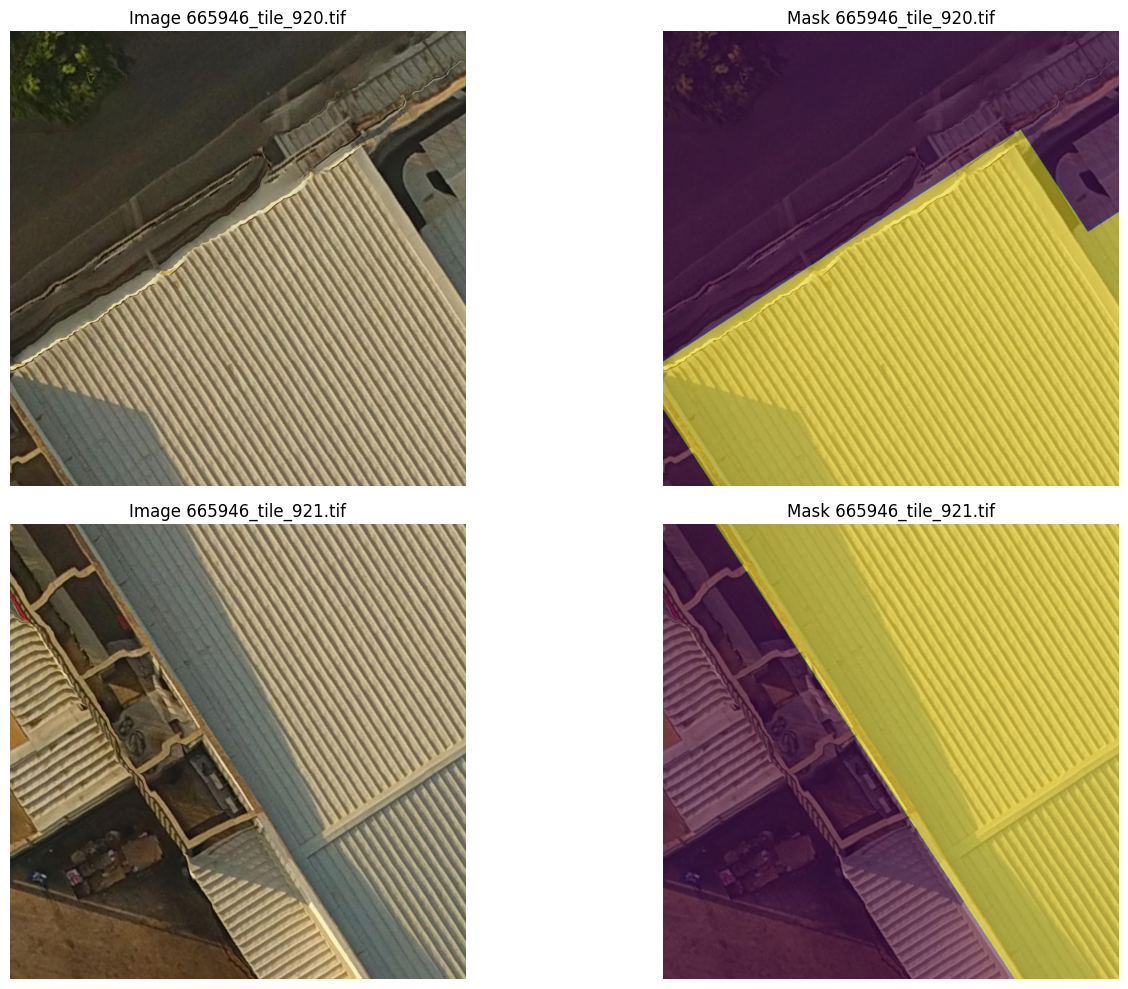

In [4]:
data.display_data(list_indices=[0,1])

### Test New Models 

In [1]:
# In a Jupyter notebook or IPython environment, run this in the first cell
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append(os.path.abspath('../src'))

In [3]:
from models import Segformer, Unet, ResNet_Unet
model_name = "nvidia/segformer-b0-finetuned-ade-512-512"
label2id = {"building": 1, "background": 0 } #{"cloud": 1, "no_cloud": 0 }
id2label = {v: k for k,v in label2id.items()}
num_labels = 2
freeze_encoder = True

model = Segformer(model_name=model_name,
                  label2id=label2id,
                  num_labels=num_labels,
                  freeze_encoder=freeze_encoder
                  )

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Encoder weights have been frozen.


In [4]:
from datasets import  OpenCities_Building_Dataset
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

base_dir = "../data/data_samples/Open-cities/training_data"
image_dir = f'{base_dir}/images'
mask_dir = f'{base_dir}/masks'

# Define Albumentations transforms with normalization
transform = A.Compose([
    # Lambda function to reshape images and masks to (H, W, C)
    A.Resize(512, 512),  # Resize if needed
    ToTensorV2()  # Convert image to PyTorch tensor (C, H, W)
], is_check_shapes=True)

segmentation_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.HorizontalFlip(p=0.5),  # Random horizontal flip with 50% probability
        A.VerticalFlip(p=0.5),    # Random vertical flip with 50% probability
        A.RandomRotate90(p=0.5),  # Random 90 degree rotation with 50% probability
        A.ShiftScaleRotate(
            shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5, border_mode=0
        ),  # Random shift, scale, and rotation with fill at borders
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),  # Adjust color properties
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),  # Adjust brightness and contrast
        A.GaussianBlur(blur_limit=(3, 5), p=0.3),  # Apply a Gaussian blur
        A.GaussNoise(var_limit=(10, 50), p=0.3),  # Add Gaussian noise
        ToTensorV2(),  # Convert to PyTorch tensors
    ], is_check_shapes=True
)

### Test Dataset 

In [49]:
# Define Albumentations transforms with normalization
transform = A.Compose([
    # Lambda function to reshape images and masks to (H, W, C)
    A.Resize(256, 256),  # Resize if needed
    A.CenterCrop(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
    # Convert image to PyTorch tensor (C, H, W)
], is_check_shapes=True)

In [5]:
data = OpenCities_Building_Dataset(
    images_dir=image_dir,
    masks_dir=mask_dir,
    transform=transform
)

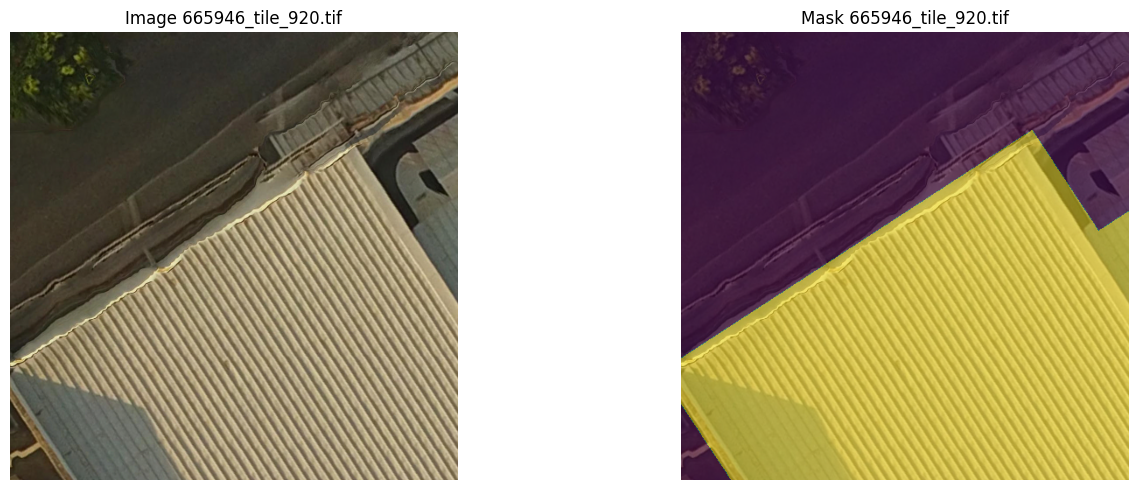

In [6]:
data.display_data(list_indices=[0])

In [7]:
data_loader = DataLoader(data, batch_size=2, shuffle=True)

In [8]:
inputs = next(iter(data_loader))

In [9]:
print(inputs["image"].shape)
print(inputs["mask"].shape)

torch.Size([2, 3, 512, 512])
torch.Size([2, 512, 512])


In [10]:
outputs = model(inputs["image"])

In [11]:
outputs.shape

torch.Size([2, 2, 512, 512])

In [ ]:
import metrics
import torch
import numpy as np

# first compute statistics for true positives, false positives, false negative and
# true negative "pixels"
tp, fp, fn, tn = metrics.get_stats(outputs, targets, num_classes=2, mode='multiclass')

# then compute metrics with required reduction (see metric docs)
iou_score = metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score = metrics.f1_score(tp, fp, fn, tn, reduction="micro")
f2_score = metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
accuracy = metrics.accuracy(tp, fp, fn, tn, reduction="macro")
recall = metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")

In [70]:
print("iou_score : ", iou_score)
print("f1_score : ", f1_score)
print("f2_score : ",f2_score)
print("accuracy : ", accuracy)
print("recall : ", recall)

iou_score :  tensor(0.3391)
f1_score :  tensor(0.5064)
f2_score :  tensor(0.5064)
accuracy :  tensor(0.5064)
recall :  tensor(0.5064)


### Test Training 

In [ ]:
# Define Albumentations transforms with normalization
valid_transform_ResNet = A.Compose([
    # Lambda function to reshape images and masks to (H, W, C)
    A.Resize(512, 512),  # Resize if needed
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()  # Convert image to PyTorch tensor (C, H, W)
], is_check_shapes=True)

training_transform_ResNet = A.Compose(
    [
        A.Resize(512, 512),
        A.HorizontalFlip(p=0.5),  # Random horizontal flip with 50% probability
        A.VerticalFlip(p=0.5),    # Random vertical flip with 50% probability
        A.RandomRotate90(p=0.5),  # Random 90 degree rotation with 50% probability
        A.ShiftScaleRotate(
            shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5, border_mode=0
        ),  # Random shift, scale, and rotation with fill at borders
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),  # Adjust color properties
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),  # Adjust brightness and contrast
        A.GaussianBlur(blur_limit=(3, 5), p=0.3),  # Apply a Gaussian blur
        A.GaussNoise(var_limit=(10, 50), p=0.3),  # Add Gaussian noise
        ToTensorV2(),  # Convert to PyTorch tensors
    ], is_check_shapes=True

In [40]:
train_data = OpenCities_Building_Dataset(
    images_dir=image_dir,
    masks_dir=mask_dir,
    transform=transform
)
valid_data = OpenCities_Building_Dataset(
    images_dir=image_dir,
    masks_dir=mask_dir,
    transform=transform
)

train_dl = DataLoader(train_data, batch_size=1, shuffle=True, pin_memory=True, num_workers=4)
valid_dl = DataLoader(valid_data, batch_size=1, shuffle=False, pin_memory=True, num_workers=4)

In [42]:
from models import Segformer, ResNet_UNET
model = ResNet_UNET()

In [43]:
from training import train 
from losses import DiceLoss, JaccardLoss
from metrics import accuracy, f1_score, recall, precision, iou_score

train(
    model=model,
    train_dl=train_dl,
    valid_dl=valid_dl,
    optimizer=None,
    scheduler=None,
    params_opt={"lr" : 1e-4},
    params_sc = None,
    loss_fn = JaccardLoss(mode="multiclass"),
    metrics = [accuracy, iou_score, recall, precision],
    nb_epochs = 20,
    experiment_name = "experiment",
    log_dir = "runs",
    model_dir = "models",
    early_stopping_params=None
)

Experiment logs are recoded at runs\experiment_20241116-021341
Epoch 1
----------
Epoch 1 Training completed. Loss: 0.6630

Metrics (Training Phase):

+---------------------------+--------+
|           Metric          | Value  |
+---------------------------+--------+
|          accuracy         | 0.4866 |
|         iou_score         | 0.3215 |
|        sensitivity        | 0.4866 |
| positive_predictive_value | 0.4866 |
+---------------------------+--------+
Epoch 1 Validation completed. Loss: 0.6675

Metrics (Validation Phase):

+---------------------------+--------+
|           Metric          | Value  |
+---------------------------+--------+
|          accuracy         | 0.4502 |
|         iou_score         | 0.2905 |
|        sensitivity        | 0.4502 |
| positive_predictive_value | 0.4502 |
+---------------------------+--------+
LOSS train 0.6629723012447357 valid 0.6675395667552948
Saving best model
Epoch 2
----------
Epoch 2 Training completed. Loss: 0.6492

Metrics (Training 

In [60]:
inputs = next(iter(valid_dl))
image = inputs["image"].to("cuda")
mask_label = inputs["mask"]
pred_mask = model.predict(image)
#pred_mask = np.where(pred_mask == 1, 255, 0)

In [56]:
import torch
import numpy as np 
import matplotlib.pyplot as plt

def display_prediction(image, mask_prediction, mask_label):
    """
    Displays an image alongside its predicted mask and ground truth mask.
    
    Args:
        image (torch.Tensor or numpy.ndarray): Input image, shape (C, H, W) or (H, W, C).
        mask_prediction (torch.Tensor or numpy.ndarray): Predicted mask, shape (H, W) or (H, W, C).
        mask_label (torch.Tensor or numpy.ndarray): Ground truth mask, shape (H, W) or (H, W, C).
    """
    # Convert tensors to numpy arrays if needed
    if isinstance(image, torch.Tensor):
        image = image.detach().cpu().numpy()
    if isinstance(mask_prediction, torch.Tensor):
        mask_prediction = mask_prediction.detach().cpu().numpy()
    if isinstance(mask_label, torch.Tensor):
        mask_label = mask_label.detach().cpu().numpy()
    
    # Handle grayscale or channel-first images
    if image.ndim == 3 and image.shape[0] in [1, 3]:  # (C, H, W) format
        image = np.transpose(image, (1, 2, 0))  # Convert to (H, W, C)
    
    # Normalize image for better visualization (if needed)
    if image.max() > 1:
        image = image / 255.0  # Assuming image is in [0, 255]
    
    # Create the plot
    plt.figure(figsize=(12, 4))
    
    # Show the input image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Input Image")
    
    # Show the predicted mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask_prediction, cmap='jet', interpolation='none')
    plt.axis('off')
    plt.title("Predicted Mask")
    
    # Show the ground truth mask
    plt.subplot(1, 3, 3)
    plt.imshow(mask_label, cmap='jet', interpolation='none')
    plt.axis('off')
    plt.title("Ground Truth Mask")
    
    plt.tight_layout()
    plt.show()

In [ ]:
import torch

# Example normalized image
image = inputs["image"]  # Your normalized image tensor (C, H, W)

# Define the mean and std for renormalization (reverse the normalization)
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)  # (C, 1, 1) to match image dimensions
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)  # (C, 1, 1) to match image dimensions

# Renormalize the image
renormalized_image = image * std + mean

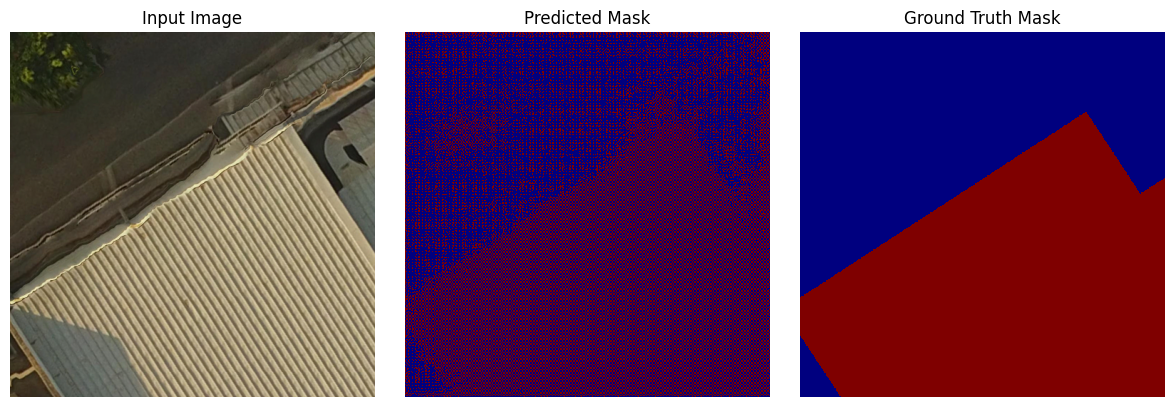

In [70]:
display_prediction(renormalized_image.squeeze(0), pred_mask.squeeze(0), mask_label.squeeze(0))